# Fine tuning on pre-trained keras model InceptionV3

In [9]:
import os 

import numpy as np
from matplotlib import pyplot
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD
from keras import callbacks
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib import pyplot
import seaborn as sns


In [2]:
path = "/home/ubuntu/nbs/data/seedlings"
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "valid")
test_path = os.path.join(path, "test")
preview_path = os.path.join(path, "preview")
checkpoint_path = os.path.join(path, "best_weights.hdf5")

### Data generator with augmentation

In [3]:
# Get batches from the dirname directory, perform augmentation (rotation, shift, flip, zoom) 
# and return batch genarator object.
def get_batches(dirname, shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(299,299)):
    gen = image.ImageDataGenerator(
                        rotation_range=180, 
                        width_shift_range=0.1, height_shift_range=0.1, 
                        horizontal_flip=True, vertical_flip=True,
                        zoom_range=0.2,
                        preprocessing_function=preprocess_input
                        )
    flow = gen.flow_from_directory(
                        dirname, 
                        shuffle=True,
                        batch_size=batch_size, 
                        class_mode='categorical',
                        target_size=target_size,
                        )

    return flow 

### Take a look at augmented images

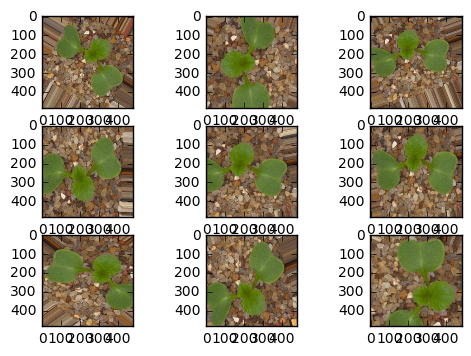

In [4]:
#Take a look at augmented images
gen = image.ImageDataGenerator(
                        rotation_range=180, 
                        width_shift_range=0.1, height_shift_range=0.1, 
                        horizontal_flip=True, vertical_flip=True,
                        zoom_range=0.2,
                        preprocessing_function=preprocess_input
                        )

img = image.load_img(os.path.join(train_path, 'Charlock/0a7e1ca41.png'))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
for z in range(9):
    batch = next(gen.flow(x, save_to_dir=preview_path, save_prefix='Black_grass', save_format='jpeg'))
    
for i, pic in enumerate(os.listdir(preview_path)[:9]):
    img = image.load_img(os.path.join(preview_path, pic))
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(img)
pyplot.show()

### Updating InceptionV3 model

In [5]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer (12 classes)
predictions = Dense(12, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# train only the top layers
# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

### Creating callbacks (early stopping and checkpoint)

In [6]:
# Early stop training if loss starts to increase duaring 2 epochs. Check point best models.
model_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=0),
]

### Train top level of model 

In [7]:
# get train and valid augmented data generators
batch_size = 64
train_batches = get_batches(train_path, batch_size=batch_size)
valid_batches = get_batches(valid_path, batch_size=batch_size)
# train model
model.fit_generator(train_batches,
                    epochs=30, 
                    validation_data=valid_batches, 
                    steps_per_epoch=10000/batch_size, 
                    validation_steps=2500/batch_size,
                    callbacks=model_callbacks,
                   )

Found 3070 images belonging to 12 classes.
Found 840 images belonging to 12 classes.
Epoch 1/30
156/156 [==============================] - 338s 2s/step - loss: 2.3556 - acc: 0.3852 - val_loss: 2.3998 - val_acc: 0.2739
Epoch 2/30
156/156 [==============================] - 309s 2s/step - loss: 1.2272 - acc: 0.5850 - val_loss: 1.5575 - val_acc: 0.4883
Epoch 3/30
156/156 [==============================] - 307s 2s/step - loss: 1.0046 - acc: 0.6547 - val_loss: 1.1398 - val_acc: 0.6003
Epoch 4/30
156/156 [==============================] - 312s 2s/step - loss: 0.8800 - acc: 0.6989 - val_loss: 1.1200 - val_acc: 0.6233
Epoch 5/30
156/156 [==============================] - 307s 2s/step - loss: 0.8047 - acc: 0.7261 - val_loss: 1.0545 - val_acc: 0.6577
Epoch 6/30
156/156 [==============================] - 304s 2s/step - loss: 0.7581 - acc: 0.7375 - val_loss: 1.0150 - val_acc: 0.6321
Epoch 7/30
156/156 [==============================] - 303s 2s/step - loss: 0.7131 - acc: 0.7529 - val_loss: 1.1244 - 

### Fine-tuning convolutional layers

In [10]:
# top layers are well trained, can start fine-tuning 
print("Number of InceptionV3 layers {}".format(len(base_model.layers)))
# freeze the first 249 layers and unfreeze the rest
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

#recompile the model with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])


# Callbacks (early stop training if loss starts to increase duaring 2 epochs. Check point best models.)
model_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=0),
]
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(train_batches, 
                    epochs=30, 
                    validation_data=valid_batches, 
                    callbacks=model_callbacks, 
                    steps_per_epoch=10000/batch_size, 
                    validation_steps=2500/batch_size)

Number of InceptionV3 layers 311
Epoch 1/30
156/156 [==============================] - 321s 2s/step - loss: 0.4462 - acc: 0.8462 - val_loss: 0.6216 - val_acc: 0.7777
Epoch 2/30
156/156 [==============================] - 306s 2s/step - loss: 0.3866 - acc: 0.8637 - val_loss: 0.6150 - val_acc: 0.7836
Epoch 3/30
156/156 [==============================] - 321s 2s/step - loss: 0.3650 - acc: 0.8731 - val_loss: 0.5651 - val_acc: 0.7878
Epoch 4/30
156/156 [==============================] - 331s 2s/step - loss: 0.3478 - acc: 0.8787 - val_loss: 0.5614 - val_acc: 0.7987
Epoch 5/30
156/156 [==============================] - 342s 2s/step - loss: 0.3160 - acc: 0.8886 - val_loss: 0.5626 - val_acc: 0.7961
Epoch 6/30
156/156 [==============================] - 335s 2s/step - loss: 0.3228 - acc: 0.8870 - val_loss: 0.5189 - val_acc: 0.8083
Epoch 7/30
156/156 [==============================] - 308s 2s/step - loss: 0.3056 - acc: 0.8922 - val_loss: 0.5146 - val_acc: 0.8175
Epoch 8/30
156/156 [================

In [11]:
scores = model.evaluate_generator(valid_batches, steps=2500/batch_size)
for i,s in enumerate(scores):
    print("{} {}".format(model.metrics_names[i], scores[i]))


loss 0.449565395313
acc 0.833053691275
